Data project:

CAPM - financial data

Choose 3 stocks and market (SP-500)
1. Data
- Import stock data from csv/api
- Merge stock data together
- Calculate expected return matrix
- Calculate covariance matrix

2. CAPM Regression
- Calculate stock regression.

![image.png](attachment:image.png)

- What is the market exposure/risk premium (Betas)
- Does CAPM hold? (Is alpha = 0)

3. CAPM: Portfolio
- Find Minimum variance portfolio and Efficient tangent portfolio (Highest sharpe ratio).
- Plot portfolios in volatility-return diagram.



In [20]:
import yfinance as yf
import pandas as pd
import numpy as np


In [30]:
#data = yf.download(["^GSPC", "BTC-USD", "META", "IVN.TO" ], start = "2020-01-01", end = "2024-04-08", interval = "1mo")
#data = data.iloc[:, :2]

data = yf.download(["^GSPC", "BTC-USD", "META", "IVN.TO"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
#Hvis vi bare downloader data uden at specificere at det er Adjusted Close, så får vi en masse vi ikke skal bruge
data = data['Adj Close']
data['sp500_returns'] = data['^GSPC'].pct_change() * 100
data["BTC_returns"] = data["BTC-USD"].pct_change() * 100
data["META_returns"] = data["META"].pct_change() * 100
data["IVN_returns"] = data["IVN.TO"].pct_change() * 100
data = data.dropna()

print(data)

[*********************100%%**********************]  4 of 4 completed

Ticker           BTC-USD     IVN.TO        META        ^GSPC  sp500_returns  \
Date                                                                          
2020-01-01   9350.529297   3.420000  201.695999  3225.520020      -0.162809   
2020-02-01   8599.508789   3.130000  192.266006  2954.219971      -8.411048   
2020-03-01   6438.644531   2.340000  166.623215  2584.590088     -12.511928   
2020-04-01   8658.553711   2.920000  204.493042  2912.429932      12.684404   
2020-05-01   9461.058594   3.050000  224.851425  3044.310059       4.528182   
2020-06-01   9137.993164   3.850000  226.829346  3100.290039       1.838840   
2020-07-01  11323.466797   4.720000  253.401138  3271.120117       5.510132   
2020-08-01  11680.820312   5.150000  292.889252  3500.310059       7.006467   
2020-09-01  10784.491211   4.840000  261.622406  3363.000000      -3.922797   
2020-10-01  13780.995117   5.240000  262.831116  3269.959961      -2.766579   
2020-11-01  19625.835938   6.080000  276.676453  362

In [90]:
#returns = data.iloc[:, [4,5,6,7]] #betyder alle rækker, og kolonne 4,5,6,7. husk at 0,1,2,3,4,5,6,7
returns = data.loc[:,['BTC_returns', 'META_returns', 'IVN_returns']]
return_matrix = np.mean(returns, axis=0)
print(return_matrix)
variance_matrix = np.var(returns, axis=0, ddof=1)
# We set the Delta Degrees of Freedom paramter to 1, such that it calculates the sample variance, so it matches the variance in the covariance matrix.
print(variance_matrix)

Ticker
BTC_returns     6.430650
META_returns    2.595073
IVN_returns     3.863787
dtype: float64
Ticker
BTC_returns     422.237380
META_returns    154.517799
IVN_returns     212.355831
dtype: float64


In [91]:
cov_matrix = returns.cov()
print(cov_matrix)

Ticker        BTC_returns  META_returns  IVN_returns
Ticker                                              
BTC_returns    422.237380     76.817097   105.260482
META_returns    76.817097    154.517799    54.224078
IVN_returns    105.260482     54.224078   212.355831


## 3 Portfolios

In [92]:
# Define portfolio function, which returns ER and Volatility for any portfolio weight x
def portfolio(return_matrix, cov_matrix, w1,w2):
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=['BTC_returns','META_returns','IVN_returns'])
    tW = W.transpose()
    var = tW.dot(cov_matrix).dot(W)
    sd = np.sqrt(var)[0][0]

    e_r = tW.dot(return_matrix)[0]

   # print(tW)
   #print(W)
    #print(var)
    #print(sd)
    return e_r, sd



In [93]:
er, sd = portfolio(return_matrix, cov_matrix, 0,0)

print(f'Expected return = {er:.3f}, Variance = {sd**2:.3f}')

Expected return = 3.864, Variance = 212.356


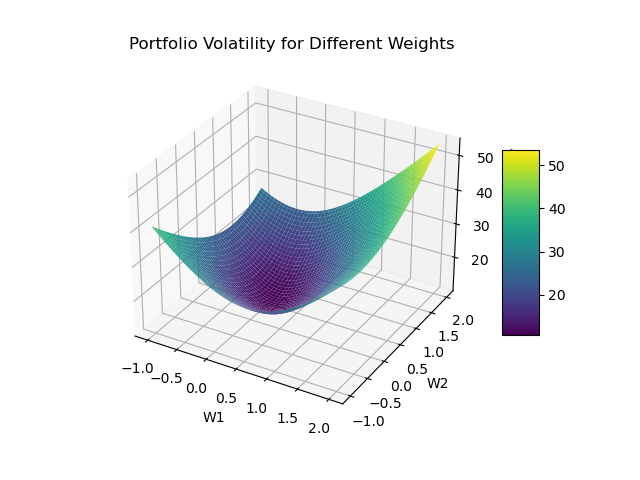

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget

# Define the function - Ensure your portfolio function is defined

# Generate the values for w1 and w2
w1_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity
w2_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity

# Create meshgrid for w1 and w2
W1, W2 = np.meshgrid(w1_values, w2_values)

# Initialize an array to hold the function values
function_values = np.zeros(W1.shape)

# Calculate the function values for each (w1, w2) pair
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1 = W1[i, j]
        w2 = W2[i, j]
        w3 = 1 - w1 - w2  # Ensure the sum of weights is 1
        # Adjust the line below if your portfolio function expects a different format
        function_values[i, j] = portfolio(return_matrix, cov_matrix, w1, w2)[1]

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(W1, W2, function_values, cmap='viridis')

# Add labels and title
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_zlabel('Portfolio Volatility')
plt.title('Portfolio Volatility for Different Weights')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [104]:
def mvp(return_matrix, cov_matrix, N):
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)
    vol_best = np.inf
    w1_best = 0
    w2_best = 0
    for w1 in w1_vec:
        for w2 in w2_vec: 
            vol = portfolio(return_matrix, cov_matrix, w1, w2)[1]
            if vol < vol_best:
                vol_best = vol
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

w1_min, w2_min = mvp(return_matrix, cov_matrix, 100)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')

#print(f'Minimum variance weights: w1 = {w_min:.3f}, w2 = {1 - w_min:.3f}')

Minimum variance weights: w1 = 0.091, w2 = 0.576, w3 = 0.333


In [105]:
mvp = portfolio(return_matrix, cov_matrix, 0.091, 0.576)
print(f'MVP return = {mvp[0]:.3f}, MVP volatility = {mvp[1]:.3f}')

MVP return = 3.367, MVP volatility = 10.656
